# Introduction


This notebook aims for providing an experiment of traditional pair trading with parameter autotuning grid search.

This experiment is based on [backtrader](https://www.backtrader.com/) which has an agnosticism philosophy that the data come in as a per-sample basis. Indicators are recalculate when new data come in.

And [Quantstat](https://github.com/ranaroussi/quantstats) for metrics and graphical analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, json, pickle
import numpy as np
import pandas as pd
import statsmodels.api as sm
import backtrader as bt
import quantstats as qs

from tqdm import tqdm
from itertools import combinations
# Find parameters in `params.py`
from params import *
from utils.deletion import clear_previous_res
from utils.gridsearch import gridsearch
from utils.read2df import read2df
from utils.cointncorr import CointnCorr
from utils.resanalyse import res_analyse
from utils.pyfolioprocess import pyfolio_process
from utils.rlmetrics import get_return, get_metrics
from envs.env_gridsearch import KellyCriterionIndicator, PairTrading

folder_path = "result/gridsearch"
os.makedirs(folder_path, exist_ok=True)

# Data Preparation

Load proper `symbols` and `freqs` from the analysis of `trade_preliminaries.ipynb`

Then is split for train data and test data from `start_date` until `trade_date`, and start trade after `trade_date`.

In [2]:
# If there is already a pickle file
cointcorr_pickle = 'result/cointncorr.pickle'

if os.path.exists(cointcorr_pickle):
    with open(cointcorr_pickle, 'rb') as pk:
        data = pickle.load(pk)
else:
    raise Error("No pickle file found, please run trade_preliminaries.ipynb first")


# dfs = read2df(symbols, freqs)
dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})


freq_position = list(freqs.keys()).index(data[1])

df0 = dfs[freq_position][dfs[freq_position]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[freq_position][dfs[freq_position]['tic']==data[0][1]].reset_index(drop=True)

pair, best_freq = data 
best_pair = f"{pair[0]}_{pair[1]}"

print("===========================================")
print(f"Data loaded as: {best_pair} under {best_freq} interval")
print("===========================================")

# have a preview
dfs[0].head(20)

Data loaded as: EURUSDT_GBPUSDT under 5m interval


,time,open,high,low,close,volume,tic,itvl,datetime
0,1595246699999,1.1383,1.1393,1.1383,1.1393,5250.60,EURUSDT,5m,2020-07-20 12:04:59.999
1,1595246699999,1.2480,2.7926,1.0174,1.2625,19670.50,GBPUSDT,5m,2020-07-20 12:04:59.999
2,1595246999999,1.1385,1.1392,1.1383,1.1388,4747.88,EURUSDT,5m,2020-07-20 12:09:59.999
3,1595246999999,1.2625,1.3445,1.2499,1.2501,6355.17,GBPUSDT,5m,2020-07-20 12:09:59.999
4,1595247299999,1.1390,1.1391,1.1390,1.1390,3494.37,EURUSDT,5m,2020-07-20 12:14:59.999
5,1595247299999,1.2506,1.2518,1.2486,1.2514,2669.78,GBPUSDT,5m,2020-07-20 12:14:59.999
6,1595247599999,1.1390,1.1390,1.1382,1.1382,14342.38,EURUSDT,5m,2020-07-20 12:19:59.999
7,1595247599999,1.2613,1.2630,1.2499,1.2516,2324.89,GBPUSDT,5m,2020-07-20 12:19:59.999
8,1595247899999,1.1382,1.1386,1.1380,1.1386,3872.60,EURUSDT,5m,2020-07-20 12:24:59.999
9,1595247899999,1.2516,1.2540,1.2514,1.2540,571.16,GBPUSDT,5m,2020-07-20 12:24:59.999


In [3]:
'''
Set data before `trade_data` as training data, after `trade_data` is trade_data
'''

trains, tests = [], []
for i in range(len(dfs)):
    trains.append(dfs[i][(dfs[i]['datetime'] > start_date) & (dfs[i]['datetime'] < trade_date)].reset_index(drop=True))
    tests.append(dfs[i][dfs[i]['datetime'] >= trade_date].reset_index(drop=True))

# Cointegration and Correlation

We need to make sure that our data is capable for pair trading. 
At least it should have the tendency to merge together therefore we test the coint and corr between every possible two pairs 

Calculate daily coint and corr for all the pairs
Consider 1 day with 1440 minutes.

Delete the pickle file in the `\result` if want to recalculate

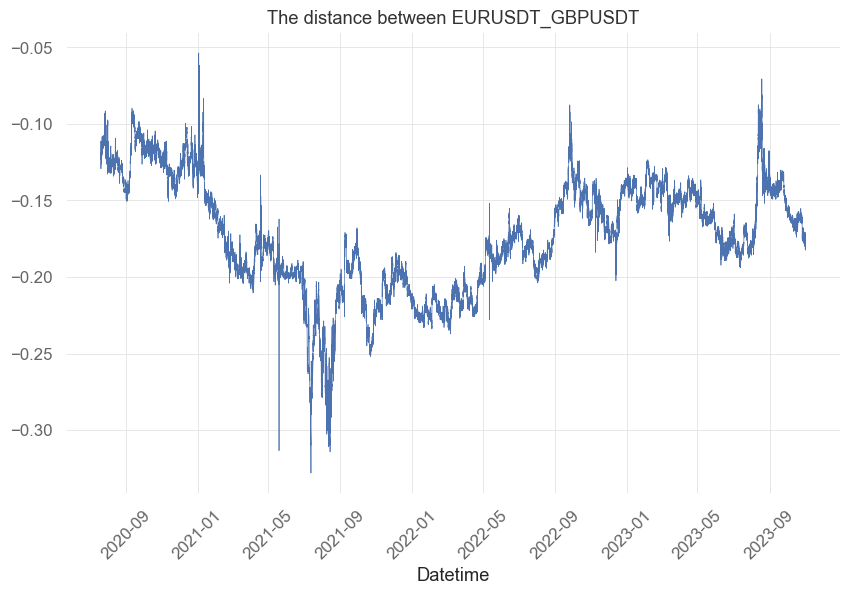

In [4]:
import matplotlib.pyplot as plt

distance = df0['close']-df1['close']
stddev = np.std(distance)

plt.plot(df0['datetime'], distance, linewidth=0.5)

# Set labels and title
plt.xlabel('Datetime')
plt.xticks(rotation=45) 

plt.title(f"The distance between {best_pair}")

# Display the plot
plt.show()

In [5]:
freq_pos = list(freqs.keys()).index(best_freq)

traindata0 = trains[freq_pos][trains[freq_pos]['tic']==best_pair.split('_')[0]].reset_index(drop=True)
traindata1 = trains[freq_pos][trains[freq_pos]['tic']==best_pair.split('_')[1]].reset_index(drop=True)

# How come a datetime of 2022(ish) is converted to 738786.635416655???
datafeed0 = bt.feeds.PandasData(
        dataname=traindata0,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

datafeed1 = bt.feeds.PandasData(
        dataname=traindata1,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

datafeeds = [datafeed0, datafeed1]
print(f"length of train set is {len(traindata0)}")

length of train set is 257345


# Execute the Strategy

We should firstly have a test run on the strategy to make sure it works.

Submitted a PR for Backtrader-OLS results

> https://github.com/mementum/backtrader/pull/487

In [6]:
def cerebro_run(datafeeds, param):

    cerebro = bt.Cerebro()

    cerebro.adddata(datafeeds[0], name=best_pair.split('_')[0])
    cerebro.adddata(datafeeds[1], name=best_pair.split('_')[1])

    cerebro.broker.set_cash(10000)  # Set initial capital

    # Binance fee structure
    # https://www.binance.com/en-BH/support/faq/binance-futures-fee-structure-fee-calculations-360033544231
    cerebro.broker.setcommission(commission=0.0002)

    # comminfo = PairTradingCommInfo(commission=0.002, margin=1000, mult=10)
    # cerebro.broker.addcommissioninfo(comminfo)

    cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')
    # cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturns', compression=60)
    # cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
    # cerebro.addsizer(KellyCriterionSizer)

    cerebro.addstrategy(PairTrading, **param)
    strats = cerebro.run()
    return strats

An Experimental Run

In [ ]:
prefix = "Experiment"
clear_previous_res(prefix)

# A test run
# https://github.com/mementum/backtrader/blob/master/backtrader/indicators/ols.py
# It always returns weird error like the number of params

# 1. The default OLS indicator is precarious, always weird errors like num of params, or sometimes index error
# 2. The custom indicator is precious as well. not trustworthy

param = {'kellycriterion': False, 'OPEN_THRE':2, 'CLOS_THRE':0.3, 'period':1300, 'verbose':1, 'prefix':prefix, 'fixed_amount':1000}
experiment = cerebro_run(datafeeds, param)

# Grid Search the Strategy

The grid search on all the possible results for an optimal outcome

Define `scoring` function and `param_grid` for grid search

then `gridsearch` from `utils.gridsearch`

In [7]:
prefix = "Gridsearch"
clear_previous_res(prefix)

datafeeds = [datafeed0, datafeed1]
freq_adjust = freqs[best_freq]

'''
Seems longer period provides better result
I guess its because the zscore is relatively stabler
'''
param_grid = {
    'OPEN_THRE': [2.2], 
    'CLOS_THRE': [0.3], 
    'period': [1400, 1600], # np.arange(800, 1200, 200),
    'verbose': [0],
    'prefix': [prefix],
    'kellycriterion': [False],
    'fixed_amount': [1000]
}

def scoring(strats):
    score = strats[0].analyzers.Returns.get_analysis()['rtot']
    return score

# included tqdm for progress bar
# Take a loooong time
best_profit, best_params, best_result = gridsearch(cerebro_run, param_grid, scoring, datafeeds)

grids_res = best_profit, best_params
with open('result/gridsearch/best_res.pickle', 'wb') as pk:
    pickle.dump(grids_res, pk)

print(f"Best parameters as: {best_params}")
print(f"Best profit as: {best_profit}")

  0%|          | 0/2 [00:00<?, ?it/s]

{'OPEN_THRE': 2.2, 'CLOS_THRE': 0.3, 'period': 1300, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 1000}


 50%|█████     | 1/2 [05:14<05:14, 314.45s/it]

{'OPEN_THRE': 2.2, 'CLOS_THRE': 0.3, 'period': 1400, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 1000}


100%|██████████| 2/2 [10:31<00:00, 315.65s/it]

Best parameters as: {'OPEN_THRE': 2.2, 'CLOS_THRE': 0.3, 'period': 1400, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 1000}
Best profit as: 0.06323099484629771


# Trade with test data

In [8]:
freq_position = list(freqs.keys()).index(best_freq)

testdata0 = tests[freq_position][tests[freq_position]['tic']==best_pair.split('_')[0]].reset_index(drop=True)
testdata1 = tests[freq_position][tests[freq_position]['tic']==best_pair.split('_')[1]].reset_index(drop=True)

test_datafeed0 = bt.feeds.PandasData(
        dataname=testdata0,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

test_datafeed1 = bt.feeds.PandasData(
        dataname=testdata1,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
)

test_datafeeds = [test_datafeed0, test_datafeed1]

In [9]:
prefix = "Test"
clear_previous_res(prefix)

bestres_pickle = 'result/best_res.pickle'

if os.path.exists(bestres_pickle):
    with open(bestres_pickle, 'rb') as pk:
        best_profit, best_params = pickle.load(pk)

best_params['verbose']=1
best_params['prefix']= prefix

test_res = cerebro_run(test_datafeeds, best_params)

Deleted: result/gridsearch/Test_EURUSDT_GBPUSDT_O22C3P140.csv

Open Threshold:2.2, Close Threshold:0.3, period: 1400

Starting Value - 10000.00

Ending   Value - 10170.06




# Analyze with Quanstats

### Analyze the grid search result

In [10]:
result_path = "result/gridsearch/"
files = os.listdir(result_path)

gridsearch_files = ([
    file for file in files if file.startswith(
        f"Gridsearch_{test_datafeed0._name}_{test_datafeed1._name}_O{int(best_params['OPEN_THRE']*10)}C{int(best_params['CLOS_THRE']*10)}P{best_params['period']}"
    )
])

test_files = ([
    file for file in files if file.startswith(
        f"Test_{test_datafeed0._name}_{test_datafeed1._name}_O{int(best_params['OPEN_THRE']*10)}C{int(best_params['CLOS_THRE']*10)}P{best_params['period']}"
    )
])

In [11]:
best_return = get_return(result_path + gridsearch_files[0])
get_metrics(best_return)

Yearly return: 3%
Total orders count: 255945
Total long action: 48538
Total short action: 48163
Won orders count: 48538
Lost orders count: 48163
Win/Loss order ratio: 1.0077860598384651
Avg order pnl: 2.4887008007778044e-07
Avg order pnl won: 6.0476235665005124e-05
Avg order pnl lost: -5.962457641887986e-05
Avg long order pnl: -6.699107253987894e-07
Avg short order pnl: 0.0


                    Strategy
------------------  ----------
Start Period        2020-07-25
End Period          2022-12-31
Risk-Free Rate      0.0%
Time in Market      38.0%

Cumulative Return   6.53%
CAGR﹪              1.81%

Sharpe              0.07
Prob. Sharpe Ratio  97.86%
Sortino             0.09
Sortino/√2          0.06
Omega               1.02

Max Drawdown        -0.99%
Longest DD Days     104

Gain/Pain Ratio     0.88
Gain/Pain (1M)      9.02

Payoff Ratio        1.01
Profit Factor       1.02
Common Sense Ratio  1.02
CPC Index           0.52
Tail Ratio          1.0
Outlier Win Ratio   10.94
Outlier Loss Ratio  2.58

MTD                 0.22%
3M                  0.6%
6M                  0.34%
YTD                 1.14%
1Y                  1.14%
3Y (ann.)           1.81%
5Y (ann.)           1.81%
10Y (ann.)          1.81%
All-time (ann.)     1.81%

Avg. Drawdown       -0.03%
Avg. Drawdown Days  2
Recovery Factor     6.46
Ulcer Index         0.0
Serenity Index      1.01


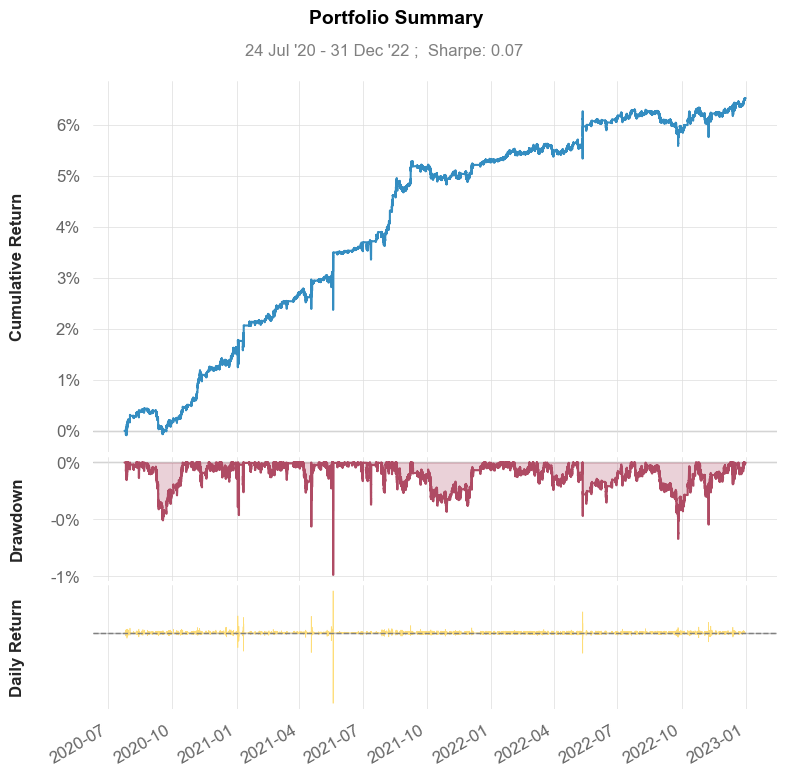

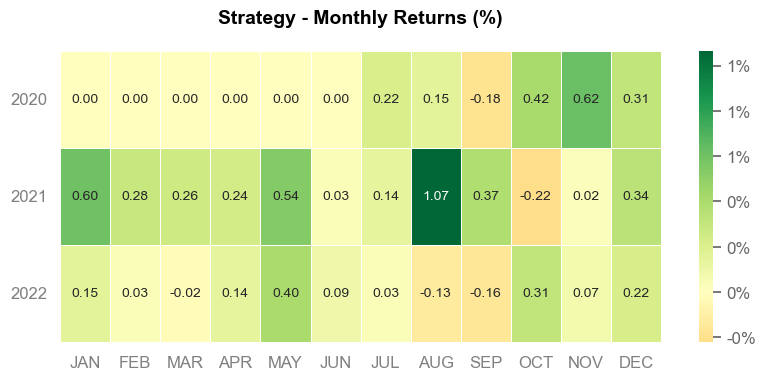

In [12]:
qs.reports.basic(best_return['returns'])

### Analyze the test result

In [13]:
test_return = get_return(result_path + test_files[0])
get_metrics(test_return)

Yearly return: 2%
Total orders count: 86135
Total long action: 14143
Total short action: 14106
Won orders count: 14143
Lost orders count: 14106
Win/Loss order ratio: 1.002622997306111
Avg order pnl: 1.9667277120003593e-07
Avg order pnl won: 5.452777420944104e-05
Avg order pnl lost: -5.3469863993818905e-05
Avg long order pnl: 0.0
Avg short order pnl: 0.0


                    Strategy
------------------  ----------
Start Period        2023-01-05
End Period          2023-10-31
Risk-Free Rate      0.0%
Time in Market      33.0%

Cumulative Return   1.7%
CAGR﹪              1.43%

Sharpe              0.07
Prob. Sharpe Ratio  91.36%
Sortino             0.11
Sortino/√2          0.07
Omega               1.02

Max Drawdown        -0.68%
Longest DD Days     53

Gain/Pain Ratio     0.67
Gain/Pain (1M)      7.12

Payoff Ratio        1.02
Profit Factor       1.02
Common Sense Ratio  1.03
CPC Index           0.52
Tail Ratio          1.01
Outlier Win Ratio   11.82
Outlier Loss Ratio  2.25

MTD                 0.15%
3M                  0.96%
6M                  1.28%
YTD                 1.7%
1Y                  1.7%
3Y (ann.)           1.43%
5Y (ann.)           1.43%
10Y (ann.)          1.43%
All-time (ann.)     1.43%

Avg. Drawdown       -0.03%
Avg. Drawdown Days  2
Recovery Factor     2.5
Ulcer Index         0.0
Serenity Index      0.24


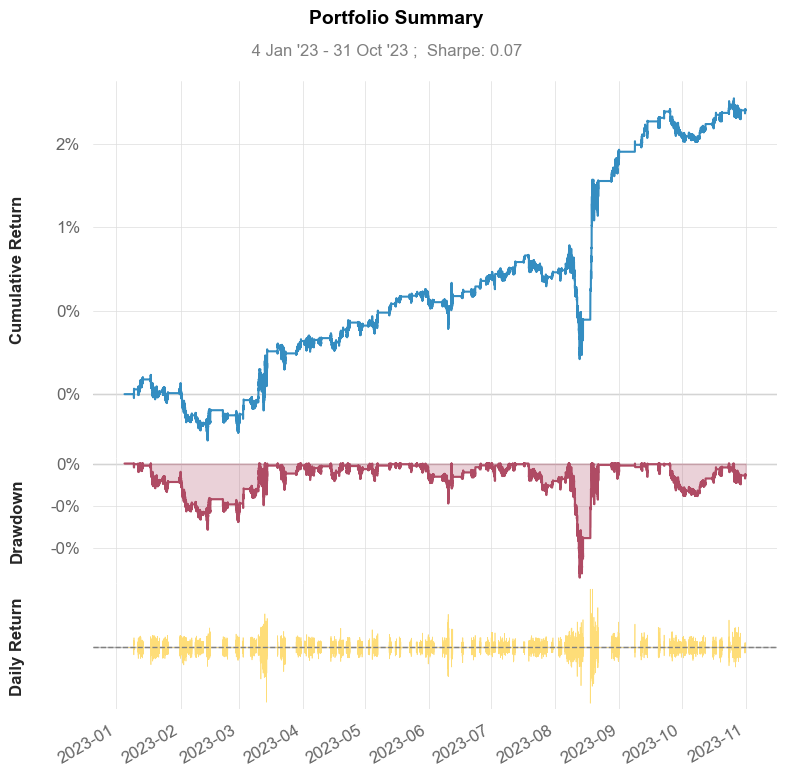

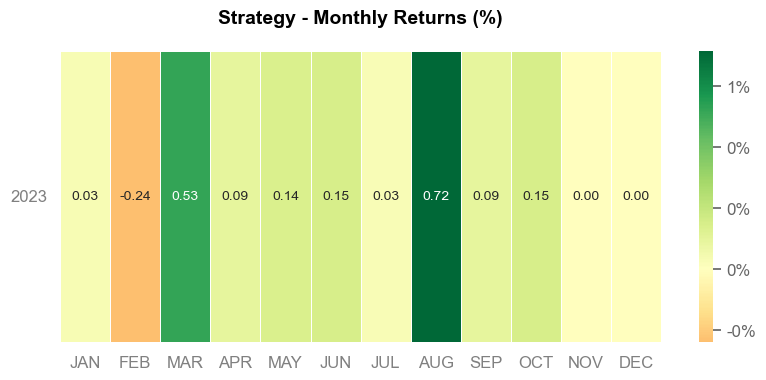

In [14]:
qs.reports.basic(test_return['returns'])